# Factors

In [15]:
library(tidyverse)
library(scales)
start_date <- ymd("1999-12-30")
end_date <- ymd("2024-3-21")

library(frenchdata)

factors_ff3_monthly_raw <- download_french_data("Fama/French 3 Factors")
factors_ff3_monthly <- factors_ff3_monthly_raw$subsets$data[[1]] |>
  mutate(
    month = floor_date(ymd(str_c(date, "01")), "month"),
    across(c(RF, `Mkt-RF`, SMB, HML), ~as.numeric(.) / 100),
    .keep = "none"
  ) |>
  rename_with(str_to_lower) |>
  rename(mkt_excess = `mkt-rf`) |> 
  filter(month >= start_date & month <= end_date)


factors_ff5_monthly_raw <- download_french_data("Fama/French 5 Factors (2x3)")

factors_ff5_monthly <- factors_ff5_monthly_raw$subsets$data[[1]] |>
  mutate(
    month = floor_date(ymd(str_c(date, "01")), "month"),
    across(c(RF, `Mkt-RF`, SMB, HML, RMW, CMA), ~as.numeric(.) / 100),
    .keep = "none"
  ) |>
  rename_with(str_to_lower) |>
  rename(mkt_excess = `mkt-rf`) |> 
  filter(month >= start_date & month <= end_date)

factors_ff3_daily_raw <- download_french_data("Fama/French 3 Factors [Daily]")

factors_ff3_daily <- factors_ff3_daily_raw$subsets$data[[1]] |>
  mutate(
    date = ymd(date),
    across(c(RF, `Mkt-RF`, SMB, HML), ~as.numeric(.) / 100),
    .keep = "none"
  ) |>
  rename_with(str_to_lower) |>
  rename(mkt_excess = `mkt-rf`) |>
  filter(date >= start_date & date <= end_date)

industries_ff_monthly_raw <- download_french_data("10 Industry Portfolios")

industries_ff_monthly <- industries_ff_monthly_raw$subsets$data[[1]] |>
  mutate(month = floor_date(ymd(str_c(date, "01")), "month")) |>
  mutate(across(where(is.numeric), ~ . / 100)) |>
  select(month, everything(), -date) |>
  filter(month >= start_date & month <= end_date) |> 
  rename_with(str_to_lower)

New names:
* `` -> `...1`
New names:
* `` -> `...1`
New names:
* `` -> `...1`
New names:
* `` -> `...1`
New names:
* `` -> `...1`
New names:
* `` -> `...1`
New names:
* `` -> `...1`
New names:
* `` -> `...1`
New names:
* `` -> `...1`
New names:
* `` -> `...1`
New names:
* `` -> `...1`
New names:
* `` -> `...1`
New names:
* `` -> `...1`


# q factors

In [16]:
factors_q_monthly_link <-
  "https://global-q.org/uploads/1/2/2/6/122679606/q5_factors_monthly_2022.csv"

factors_q_monthly <- read_csv(factors_q_monthly_link) |>
  mutate(month = ymd(str_c(year, month, "01", sep = "-"))) |>
  select(-R_F, -R_MKT, -year) |>
  rename_with(~ str_remove(., "R_")) |>
  rename_with(~ str_to_lower(.)) |>
  mutate(across(-month, ~ . / 100)) |>
  filter(month >= start_date & month <= end_date)

Rows: 672 Columns: 8
-- Column specification --------------------------------------------------------
Delimiter: ","
dbl (8): year, month, R_F, R_MKT, R_ME, R_IA, R_ROE, R_EG

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.


# Macroeconomic Predictors

In [17]:
library(readxl)
library(googledrive)
drive_deauth()

macro_predictors_link <-
  "https://docs.google.com/spreadsheets/d/1g4LOaRj4TvwJr9RIaA_nwrXXWTOy46bP"

drive_download(
  macro_predictors_link,
  path = "macro_predictors.xlsx"
)

macro_predictors <- read_xlsx(
  "macro_predictors.xlsx",
  sheet = "Monthly"
) |>
  mutate(month = ym(yyyymm)) |>
  mutate(across(where(is.character), as.numeric)) |>
  mutate(
    IndexDiv = Index + D12,
    logret = log(IndexDiv) - log(lag(IndexDiv)),
    Rfree = log(Rfree + 1),
    rp_div = lead(logret - Rfree, 1), # Future excess market return
    dp = log(D12) - log(Index), # Dividend Price ratio
    dy = log(D12) - log(lag(Index)), # Dividend yield
    ep = log(E12) - log(Index), # Earnings price ratio
    de = log(D12) - log(E12), # Dividend payout ratio
    tms = lty - tbl, # Term spread
    dfy = BAA - AAA # Default yield spread
  ) |>
  select(month, rp_div, dp, dy, ep, de, svar,
    bm = `b/m`, ntis, tbl, lty, ltr,
    tms, dfy, infl
  ) |>
  filter(month >= start_date & month <= end_date) |>
  drop_na()

  file.remove("macro_predictors.xlsx")

File downloaded:

* PredictorData2022.xlsx <id:<U+00A0>1g4LOaRj4TvwJr9RIaA_nwrXXWTOy46bP>

Saved locally as:

* macro_predictors.xlsx



[1] TRUE

# Others (Federal Reserve Economic Data (FRED))

In [18]:
library(tidyquant)

cpi_monthly <- tq_get("CPIAUCNS",
  get = "economic.data",
  from = start_date,
  to = end_date
) |>
  mutate(
    month = floor_date(date, "month"),
    cpi = price / price[month == max(month)],
    .keep = "none"
  )

# My database MySQL

In [19]:
library(RSQLite)
library(dbplyr)

tidy_finance <- dbConnect(
  SQLite(),
  "data/tidy_finance_r.sqlite",
  extended_types = TRUE
)

dbWriteTable(tidy_finance,
  "factors_ff3_monthly",
  value = factors_ff3_monthly,
  overwrite = TRUE
)

factors_ff3_monthly_db <- tbl(tidy_finance, "factors_ff3_monthly")

factors_ff3_monthly_db |>
  select(month, rf)

factors_ff3_monthly_db |>
  select(month, rf) |>
  collect()

dbWriteTable(tidy_finance,
  "factors_ff5_monthly",
  value = factors_ff5_monthly,
  overwrite = TRUE
)

dbWriteTable(tidy_finance,
  "factors_ff3_daily",
  value = factors_ff3_daily,
  overwrite = TRUE
)

dbWriteTable(tidy_finance,
  "industries_ff_monthly",
  value = industries_ff_monthly,
  overwrite = TRUE
)

dbWriteTable(tidy_finance,
  "factors_q_monthly",
  value = factors_q_monthly,
  overwrite = TRUE
)

dbWriteTable(tidy_finance,
  "macro_predictors",
  value = macro_predictors,
  overwrite = TRUE
)

dbWriteTable(tidy_finance,
  "cpi_monthly",
  value = cpi_monthly,
  overwrite = TRUE
)

library(tidyverse)
library(RSQLite)

tidy_finance <- dbConnect(
  SQLite(),
  "data/tidy_finance_r.sqlite",
  extended_types = TRUE
)

factors_q_monthly <- tbl(tidy_finance, "factors_q_monthly")
factors_q_monthly <- factors_q_monthly |> collect()

res <- dbSendQuery(tidy_finance, "VACUUM")
res

dbClearResult(res)

dbListTables(tidy_finance)

# Source:   SQL [?? x 2]
# Database: sqlite 3.45.0 [/Users/yunbo/Documents/GitHub/Quant/ML_for_trading/Asset Pricing/data/tidy_finance_r.sqlite]
   month          rf
   <date>      <dbl>
 1 2000-01-01 0.0041
 2 2000-02-01 0.0043
 3 2000-03-01 0.0047
 4 2000-04-01 0.0046
 5 2000-05-01 0.005 
 6 2000-06-01 0.004 
 7 2000-07-01 0.0048
 8 2000-08-01 0.005 
 9 2000-09-01 0.0051
10 2000-10-01 0.0056
# i more rows

month,rf
<date>,<dbl>
2000-01-01,0.0041
2000-02-01,0.0043
2000-03-01,0.0047
2000-04-01,0.0046
2000-05-01,0.0050
2000-06-01,0.0040
2000-07-01,0.0048
2000-08-01,0.0050
2000-09-01,0.0051


<SQLiteResult>
  SQL  VACUUM
  ROWS Fetched: 0 [complete]
       Changed: 0

[1] "compustat"             "cpi_monthly"           "crsp_monthly"         
[4] "factors_ff3_daily"     "factors_ff3_monthly"   "factors_ff5_monthly"  
[7] "factors_q_monthly"     "industries_ff_monthly" "macro_predictors"

In [20]:
dbListTables(tidy_finance)

[1] "compustat"             "cpi_monthly"           "crsp_monthly"         
[4] "factors_ff3_daily"     "factors_ff3_monthly"   "factors_ff5_monthly"  
[7] "factors_q_monthly"     "industries_ff_monthly" "macro_predictors"

# WRDS

In [21]:
library(tidyverse)
library(scales)
library(RSQLite)
library(dbplyr)

start_date <- ymd("1999-12-30")
end_date <- ymd("2024-3-21")

library(RPostgres)

wrds <- dbConnect(
  Postgres(),
  host = "wrds-pgdata.wharton.upenn.edu",
  dbname = "wrds",
  port = 9737,
  sslmode = "require",
  user = Sys.getenv("econmphi"),
  password = Sys.getenv("Ko8ac9Ufi4tE")
)

msf_db <- tbl(wrds, in_schema("crsp", "msf"))
msenames_db <- tbl(wrds, in_schema("crsp", "msenames"))
msedelist_db <- tbl(wrds, in_schema("crsp", "msedelist"))


In [22]:
crsp_monthly <- msf_db |>
  filter(date >= start_date & date <= end_date) |>
  inner_join(
    msenames_db |>
      filter(shrcd %in% c(10, 11)) |>
      select(permno, exchcd, siccd, namedt, nameendt),
    join_by(permno)
  ) |>
  filter(date >= namedt & date <= nameendt) |>
  mutate(month = floor_date(date, "month")) |>
  left_join(
    msedelist_db |>
      select(permno, dlstdt, dlret, dlstcd) |>
      mutate(month = floor_date(dlstdt, "month")),
    join_by(permno, month)
  ) |>
  select(
    permno, # Security identifier
    date, # Date of the observation
    month, # Month of the observation
    ret, # Return
    shrout, # Shares outstanding (in thousands)
    altprc, # Last traded price in a month
    exchcd, # Exchange code
    siccd, # Industry code
    dlret, # Delisting return
    dlstcd # Delisting code
  ) |>
  collect() |>
  mutate(
    month = ymd(month),
    shrout = shrout * 1000
  )
  

In [23]:
crsp_monthly <- crsp_monthly |>
  mutate(
    mktcap = abs(shrout * altprc) / 10^6,
    mktcap = na_if(mktcap, 0)
  )

mktcap_lag <- crsp_monthly |>
  mutate(month = month %m+% months(1)) |>
  select(permno, month, mktcap_lag = mktcap)

crsp_monthly <- crsp_monthly |>
  left_join(mktcap_lag, join_by(permno, month))

crsp_monthly <- crsp_monthly |>
  mutate(exchange = case_when(
    exchcd %in% c(1, 31) ~ "NYSE",
    exchcd %in% c(2, 32) ~ "AMEX",
    exchcd %in% c(3, 33) ~ "NASDAQ",
    .default = "Other"
  ))

crsp_monthly <- crsp_monthly |>
  mutate(industry = case_when(
    siccd >= 1 & siccd <= 999 ~ "Agriculture",
    siccd >= 1000 & siccd <= 1499 ~ "Mining",
    siccd >= 1500 & siccd <= 1799 ~ "Construction",
    siccd >= 2000 & siccd <= 3999 ~ "Manufacturing",
    siccd >= 4000 & siccd <= 4899 ~ "Transportation",
    siccd >= 4900 & siccd <= 4999 ~ "Utilities",
    siccd >= 5000 & siccd <= 5199 ~ "Wholesale",
    siccd >= 5200 & siccd <= 5999 ~ "Retail",
    siccd >= 6000 & siccd <= 6799 ~ "Finance",
    siccd >= 7000 & siccd <= 8999 ~ "Services",
    siccd >= 9000 & siccd <= 9999 ~ "Public",
    .default = "Missing"
  ))

crsp_monthly <- crsp_monthly |>
  mutate(ret_adj = case_when(
    is.na(dlstcd) ~ ret,
    !is.na(dlstcd) & !is.na(dlret) ~ dlret,
    dlstcd %in% c(500, 520, 580, 584) |
      (dlstcd >= 551 & dlstcd <= 574) ~ -0.30,
    dlstcd == 100 ~ ret,
    .default = -1
  )) |>
  select(-c(dlret, dlstcd))


tidy_finance <- dbConnect(
  SQLite(),
  "data/tidy_finance_r.sqlite",
  extended_types = TRUE
)

factors_ff3_monthly <- tbl(tidy_finance, "factors_ff3_monthly") |>
  select(month, rf) |>
  collect()

crsp_monthly <- crsp_monthly |>
  left_join(factors_ff3_monthly,
    join_by(month)
  ) |>
  mutate(
    ret_excess = ret_adj - rf,
    ret_excess = pmax(ret_excess, -1)
  ) |>
  select(-ret_adj, -rf)

crsp_monthly <- crsp_monthly |>
  drop_na(ret_excess, mktcap, mktcap_lag)

dbWriteTable(tidy_finance,
  "crsp_monthly",
  value = crsp_monthly,
  overwrite = TRUE
)

# Daily CRSP Data

In [24]:
# dsf_db <- tbl(wrds, in_schema("crsp", "dsf"))

# factors_ff3_daily <- tbl(tidy_finance, "factors_ff3_daily") |>
#   collect()

# permnos <- tbl(tidy_finance, "crsp_monthly") |>
#   distinct(permno) |>
#   pull()

# batch_size <- 500
# batches <- ceiling(length(permnos) / batch_size)

# for (j in 1:batches) {
  
#   permno_batch <- permnos[
#     ((j - 1) * batch_size + 1):min(j * batch_size, length(permnos))
#   ]

#   crsp_daily_sub <- dsf_db |>
#     filter(permno %in% permno_batch &
#              date >= start_date & date <= end_date) |>
#     select(permno, date, ret) |>
#     collect() |>
#     drop_na()

#   if (nrow(crsp_daily_sub) > 0) {
    
#     msedelist_sub <- msedelist_db |> 
#     filter(permno %in% permno_batch) |> 
#     select(permno, dlstdt, dlret) |> 
#     collect() |>
#     drop_na()
    
#     crsp_daily_sub <- crsp_daily_sub |> 
#       left_join(msedelist_sub, join_by(permno, date == dlstdt)) |> 
#       bind_rows(msedelist_sub |> 
#                   anti_join(crsp_daily_sub, 
#                             join_by(permno, dlstdt == date))) |> 
#       mutate(ret = if_else(!is.na(dlret), dlret, ret),
#              date = if_else(!is.na(dlstdt), dlstdt, date)) |> 
#       select(-c(dlret, dlstdt)) |> 
#       left_join(msedelist_sub |> 
#                   select(permno, dlstdt), join_by(permno)) |> 
#       mutate(dlstdt = replace_na(dlstdt, end_date)) |> 
#       filter(date <= dlstdt) |> 
#       select(-dlstdt)
    
#     crsp_daily_sub <- crsp_daily_sub |>
#       mutate(month = floor_date(date, "month")) |>
#       left_join(factors_ff3_daily |>
#         select(date, rf), join_by(date)) |>
#       mutate(
#         ret_excess = ret - rf,
#         ret_excess = pmax(ret_excess, -1)
#       ) |>
#       select(permno, date, month, ret, ret_excess)

#     dbWriteTable(tidy_finance,
#       "crsp_daily",
#       value = crsp_daily_sub,
#       overwrite = ifelse(j == 1, TRUE, FALSE),
#       append = ifelse(j != 1, TRUE, FALSE)
#     )
#   }

#   cat("Batch", j, "out of", batches, "done (", percent(j / batches), ")\n")
# }

# Compustat data

In [25]:
funda_db <- tbl(wrds, in_schema("comp", "funda"))

compustat <- funda_db |>
  filter(
    indfmt == "INDL" &
      datafmt == "STD" &
      consol == "C" &
      datadate >= start_date & datadate <= end_date
  ) |>
  select(
    gvkey, # Firm identifier
    datadate, # Date of the accounting data
    seq, # Stockholders' equity
    ceq, # Total common/ordinary equity
    at, # Total assets
    lt, # Total liabilities
    txditc, # Deferred taxes and investment tax credit
    txdb, # Deferred taxes
    itcb, # Investment tax credit
    pstkrv, # Preferred stock redemption value
    pstkl, # Preferred stock liquidating value
    pstk, # Preferred stock par value
    capx, # Capital investment
    oancf, # Operating cash flow
    sale,  # Revenue
    cogs, # Costs of goods sold
    xint, # Interest expense
    xsga # Selling, general, and administrative expenses
  ) |>
  collect()

compustat <- compustat |>
  mutate(
    be = coalesce(seq, ceq + pstk, at - lt) +
      coalesce(txditc, txdb + itcb, 0) -
      coalesce(pstkrv, pstkl, pstk, 0),
    be = if_else(be <= 0, NA, be),
    op = (sale - coalesce(cogs, 0) - 
            coalesce(xsga, 0) - coalesce(xint, 0)) / be,
  )

compustat <- compustat |>
  mutate(year = year(datadate)) |>
  group_by(gvkey, year) |>
  filter(datadate == max(datadate)) |>
  ungroup()

compustat <- compustat |> 
  left_join(
    compustat |> 
      select(gvkey, year, at_lag = at) |> 
      mutate(year = year + 1), 
    join_by(gvkey, year)
  ) |> 
  mutate(
    inv = at / at_lag - 1,
    inv = if_else(at_lag <= 0, NA, inv)
  )

dbWriteTable(tidy_finance,
  "compustat",
  value = compustat,
  overwrite = TRUE
)

# Merging

In [26]:
ccmxpf_linktable_db <- tbl(
  wrds,
  in_schema("crsp", "ccmxpf_linktable")
)

ccmxpf_linktable <- ccmxpf_linktable_db |>
  filter(linktype %in% c("LU", "LC") &
    linkprim %in% c("P", "C") &
    usedflag == 1) |>
  select(permno = lpermno, gvkey, linkdt, linkenddt) |>
  collect() |>
  mutate(linkenddt = replace_na(linkenddt, today()))

ccm_links <- crsp_monthly |>
  inner_join(ccmxpf_linktable, 
             join_by(permno), relationship = "many-to-many") |>
  filter(!is.na(gvkey) & 
           (date >= linkdt & date <= linkenddt)) |>
  select(permno, gvkey, date)

crsp_monthly <- crsp_monthly |>
  left_join(ccm_links, join_by(permno, date))


dbWriteTable(tidy_finance,
  "crsp_monthly",
  value = crsp_monthly,
  overwrite = TRUE
)


# Visualization

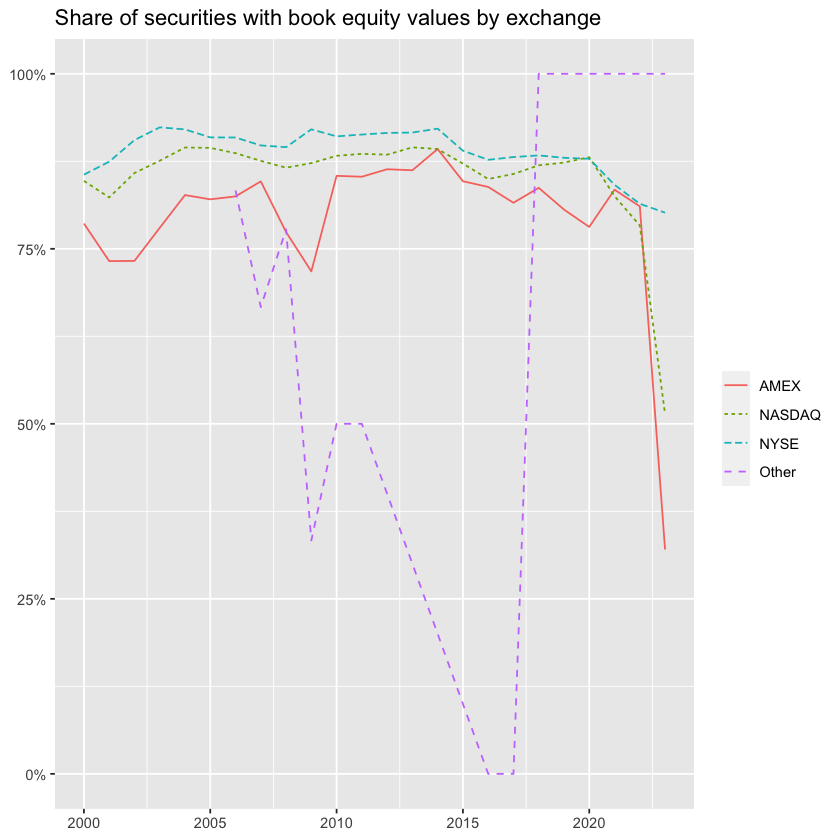

In [27]:
crsp_monthly |>
  group_by(permno, year = year(month)) |>
  filter(date == max(date)) |>
  ungroup() |>
  left_join(compustat, join_by(gvkey, year)) |>
  group_by(exchange, year) |>
  summarize(
    share = n_distinct(permno[!is.na(be)]) / n_distinct(permno),
    .groups = "drop"
  ) |>
  ggplot(aes(
    x = year, 
    y = share, 
    color = exchange,
    linetype = exchange
    )) +
  geom_line() +
  labs(
    x = NULL, y = NULL, color = NULL, linetype = NULL,
    title = "Share of securities with book equity values by exchange"
  ) +
  scale_y_continuous(labels = percent) +
  coord_cartesian(ylim = c(0, 1))

# Summary

In [28]:
dbListTables(tidy_finance)

[1] "compustat"             "cpi_monthly"           "crsp_monthly"         
[4] "factors_ff3_daily"     "factors_ff3_monthly"   "factors_ff5_monthly"  
[7] "factors_q_monthly"     "industries_ff_monthly" "macro_predictors"